# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

# Load Data

In [37]:
map_data_folder = Path("../experiments/test-eval")
all_frames = [pd.read_pickle(f) for f in map_data_folder.glob("*.pkl")]
all_data = pd.concat(all_frames)

# Utility Functions

In [21]:
def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")

# Performance Curves

For the subsequent plots, we only want to evaluate on classes seen so far, so let's insert NaN values in places where the class had not yet been trained on.

In [51]:
# Nix all rows where classes_trained <= class_id.
classes_seen_perf = all_data.copy()
unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <= 
               classes_seen_perf.index.get_level_values("class_id"))
classes_seen_perf[unseen_rows] = np.nan

First, performance for each learning rate separately.

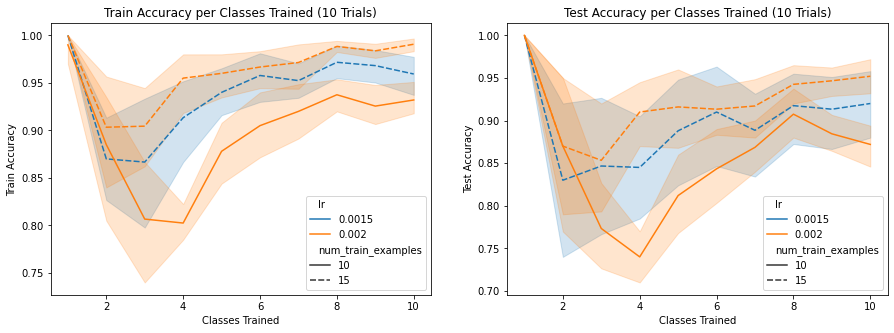

In [52]:
# For each training configuration, get a series of average performance per classes trained.
# First, we want to average over all classes to get overall performance numbers.
groupby_labels = ["model", "dataset", "num_train_examples", "num_test_examples", "lr", "classes_trained", "trial"]
over_all_classes = classes_seen_perf.groupby(groupby_labels).mean()

# And finally we want to plot the result for each learning rate.
def plot_traj_per_lr(df, metric_name, colname, ax=None):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["model", "dataset", "num_test_examples"])
    ax = sns.lineplot(
        data=df,
        x="classes_trained",
        y=colname,
        hue="lr",
        style="num_train_examples",
        palette="tab10",
        ax=ax,
    )
    ntrials = df.index.get_level_values("trial").nunique()
    ax.set_title(f"{metric_name} per Classes Trained ({ntrials} Trials)")
    ax.set_xlabel("Classes Trained")
    ax.set_ylabel(metric_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_traj_per_lr(over_all_classes, "Train Accuracy", "train_acc", ax=ax1)
plot_traj_per_lr(over_all_classes, "Test Accuracy", "test_acc", ax=ax2)

Now, best learning rate per data point.

In [36]:
# First group the potential data for each data point separately. This consists of groups over all trials and all
# learning rates.
train_cfg_cols = ["model", "dataset", "num_train_examples", "num_test_examples", "classes_trained"]
train_cfg_groups = over_all_classes.groupby(train_cfg_cols)

def select_best_lr(train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    best_lr = train_group.groupby("lr").mean()#.max()
    display(train_group)
    print(best_lr)
    print()
    return best_lr

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
train_cfg_groups.apply(select_best_lr)

epoch  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial          
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 10              0        4.5   
                                                                                                                      1        4.5   
                                                                                                                      2        4.5   
                                                                                                                      3        4.5   
                                                                                                                      4        4.5   
                                                                                                                      5        4.5   
                                                                                                                      6        4.5   
                                                                                                                      7        4.5   
                                                                                                                      8        4.5   
                                                                                                                      9        4.5   

                                                                                                                             class_id  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial             
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 10              0           4.5   
                                                                                                                      1           4.5   
                                                                                                                      2           4.5   
                                                                                                                      3           4.5   
                                                                                                                      4           4.5   
                                                                                                                      5           4.5   
                                                                                                                      6           4.5   
                                                                                                                      7           4.5   
                                                                                                                      8           4.5   
                                                                                                                      9           4.5   

                                                                                                                             train_acc  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial              
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 10              0          0.493   
                                                                                                                      1          0.503   
                                                                                                                      2          0.518   
                                                                                                                      3          0.489   
                                           

       epoch  class_id  train_acc  test_acc
lr                                         
0.002    4.5       4.5     0.4989    0.4704



epoch  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial          
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 11              0       10.0   
                                                                                                                      1       10.0   
                                                                                                                      2       10.0   
                                                                                                                      3       10.0   
                                                                                                                      4       10.0   
                                                                                                                      5       10.0   
                                                                                                                      6       10.0   
                                                                                                                      7       10.0   
                                                                                                                      8       10.0   
                                                                                                                      9       10.0   

                                                                                                                             class_id  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial             
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 11              0           4.5   
                                                                                                                      1           4.5   
                                                                                                                      2           4.5   
                                                                                                                      3           4.5   
                                                                                                                      4           4.5   
                                                                                                                      5           4.5   
                                                                                                                      6           4.5   
                                                                                                                      7           4.5   
                                                                                                                      8           4.5   
                                                                                                                      9           4.5   

                                                                                                                             train_acc  \
model                                              dataset num_train_examples num_test_examples lr    classes_trained trial              
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 0.002 11              0           0.92   
                                                                                                                      1           0.96   
                                                                                                                      2           0.99   
                                                                                                                      3           0.99   
                                           

       epoch  class_id  train_acc  test_acc
lr                                         
0.002   10.0       4.5      0.961     0.898



epoch  \
model                                              dataset num_train_examples num_test_examples lr     classes_trained trial          
/Users/ntraft/Development/higherANML/trained_an... omni    15                 5                 0.0015 10              0        4.5   
                                                                                                                       1        4.5   
                                                                                                                       2        4.5   
                                                                                                                       3        4.5   
                                                                                                                       4        4.5   
                                                                                                                       5        4.5   
                                                                                                                       6        4.5   
                                                                                                                       7        4.5   
                                                                                                                       8        4.5   
                                                                                                                       9        4.5   
                                                                                                0.0020 10              0        4.5   
                                                                                                                       1        4.5   
                                                                                                                       2        4.5   
                                                                                                                       3        4.5   
                                                                                                                       4        4.5   
                                                                                                                       5        4.5   
                                                                                                                       6        4.5   
                                                                                                                       7        4.5   
                                                                                                                       8        4.5   
                                                                                                                       9        4.5   

                                                                                                                              class_id  \
model                                              dataset num_train_examples num_test_examples lr     classes_trained trial             
/Users/ntraft/Development/higherANML/trained_an... omni    15                 5                 0.0015 10              0           4.5   
                                                                                                                       1           4.5   
                                                                                                                       2           4.5   
                                                                                                                       3           4.5   
                                                                                                                       4           4.5   
                                                                                                                       5           4.5   
                                                   

        epoch  class_id  train_acc  test_acc
lr                                          
0.0015    4.5       4.5   0.520867    0.4872
0.0020    4.5       4.5   0.532200    0.5208



epoch  \
model                                              dataset num_train_examples num_test_examples lr     classes_trained trial          
/Users/ntraft/Development/higherANML/trained_an... omni    15                 5                 0.0015 11              0       10.0   
                                                                                                                       1       10.0   
                                                                                                                       2       10.0   
                                                                                                                       3       10.0   
                                                                                                                       4       10.0   
                                                                                                                       5       10.0   
                                                                                                                       6       10.0   
                                                                                                                       7       10.0   
                                                                                                                       8       10.0   
                                                                                                                       9       10.0   
                                                                                                0.0020 11              0       10.0   
                                                                                                                       1       10.0   
                                                                                                                       2       10.0   
                                                                                                                       3       10.0   
                                                                                                                       4       10.0   
                                                                                                                       5       10.0   
                                                                                                                       6       10.0   
                                                                                                                       7       10.0   
                                                                                                                       8       10.0   
                                                                                                                       9       10.0   

                                                                                                                              class_id  \
model                                              dataset num_train_examples num_test_examples lr     classes_trained trial             
/Users/ntraft/Development/higherANML/trained_an... omni    15                 5                 0.0015 11              0           4.5   
                                                                                                                       1           4.5   
                                                                                                                       2           4.5   
                                                                                                                       3           4.5   
                                                                                                                       4           4.5   
                                                                                                                       5           4.5   
                                                   

        epoch  class_id  train_acc  test_acc
lr                                          
0.0015   10.0       4.5   0.976667     0.918
0.0020   10.0       4.5   0.991333     0.952



epoch  \
model                                              dataset num_train_examples num_test_examples classes_trained lr              
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 10              0.0020    4.5   
                                                                                                11              0.0020   10.0   
                                                           15                 5                 10              0.0015    4.5   
                                                                                                                0.0020    4.5   
                                                                                                11              0.0015   10.0   
                                                                                                                0.0020   10.0   

                                                                                                                        class_id  \
model                                              dataset num_train_examples num_test_examples classes_trained lr                 
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 10              0.0020       4.5   
                                                                                                11              0.0020       4.5   
                                                           15                 5                 10              0.0015       4.5   
                                                                                                                0.0020       4.5   
                                                                                                11              0.0015       4.5   
                                                                                                                0.0020       4.5   

                                                                                                                        train_acc  \
model                                              dataset num_train_examples num_test_examples classes_trained lr                  
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 10              0.0020   0.498900   
                                                                                                11              0.0020   0.961000   
                                                           15                 5                 10              0.0015   0.520867   
                                                                                                                0.0020   0.532200   
                                                                                                11              0.0015   0.976667   
                                                                                                                0.0020   0.991333   

                                                                                                                        test_acc  
model                                              dataset num_train_examples num_test_examples classes_trained lr                
/Users/ntraft/Development/higherANML/trained_an... omni    10                 5                 10              0.0020    0.4704  
                                                                                                11              0.0020    0.8980  
                                                           15                 5                 10              0.0015    0.4872  
                                                                                                                0.0020    0.5208  
                                                                                                11              0.0015    0.9180  
                                                

# Scratch Space

In [20]:
per_trial_trajs.index.get_level_values("num_train_examples").unique()

Int64Index([10, 15], dtype='int64', name='num_train_examples')